<a href="https://colab.research.google.com/github/LakshmanPalli/lending-club-project/blob/main/Lending_Club_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting LendingClub Loan Charge-offs from Initial Listing Data


**June 14, 2018**

## Table of Contents

* [1. Introduction](#1)
 * [1.1 References](#1.1)
* [2. Import the Data](#2)
* [3. Response Variable](#3)
* [4. Limit the Feature Space](#4)
 * [4.1 Drop features missing more than 30% data](#4.1)
 * [4.2 Only keep loan features known to potential investors](#4.2)
* [5. Pre-processing and Exploratory Analysis](#5)
* [6. More Pre-processing](#6)
 * [6.1 Convert loan status to 0/1 charge-off indicator](#6.1)
 * [6.2 Create dummy variables](#6.2)
 * [6.3 Train/test split](#6.3)
* [7. Linear Dependence of Charge-off on the Predictors](#7)
* [8. Model Training and Testing](#8)
 * [8.1 Logistic regression with SGD training](#8.1)
 * [8.2 k-nearest neighbors](#8.2)
 * [8.3 k-nearest neighbors](#8.3)
 * [8.4 Neural Networks](#8.4)
 * [8.5 Tune hyperparameters on the chosen model more finely](#8.5)
 * [8.6 Test set evaluation](#8.6)
* [9. Conclusion](#9)

# 1. Introduction
<a id="1"></a>

[LendingClub](https://www.lendingclub.com/) is a US peer-to-peer lending company and the world's largest peer-to-peer lending platform. As explained by [Wikipedia](https://en.wikipedia.org/wiki/Lending_Club),

> Lending Club enables borrowers to create unsecured personal loans between \$1,000 and \$40,000. The standard loan period is three years. Investors can search and browse the loan listings on Lending Club website and select loans that they want to invest in based on the information supplied about the borrower, amount of loan, loan grade, and loan purpose. Investors make money from interest. Lending Club makes money by charging borrowers an origination fee and investors a service fee.

The goal of this project is to build a machine learning model to predict the probability that a loan will charge off. We will attempt to only use data available to investors via the LendingClub loan listing, including information about the borrower (income, employment length, FICO score, debt-to-income ratio, etc.) and the loan listing (the loan amount, loan purpose, loan grade, interest rate, installment, etc.). Such a predictive model could help LendingClub investors make better-informed investment decisions. We will only consider loans that LendingClub accepted under its credit underwriting policy.

## 1.1 References
<a id="1.1"></a>

* LendingClub information
 * [LendingClub website](https://www.lendingclub.com/)
 * [LendingClub Wikipedia page](https://en.wikipedia.org/wiki/Lending_Club)
* Datasets
 * [LendingClub statistics](https://www.lendingclub.com/info/download-data.action) - Original data source, aggregated on Kaggle
 * [All Lending Club loan data](https://www.kaggle.com/wordsforthewise/lending-club) - The dataset used in this project, hosted on Kaggle
 * [Lending Club Loan Data](https://www.kaggle.com/wendykan/lending-club-loan-data) - Another LendingClub dataset on Kaggle, not used in this project


# 2. Import the Data
<a id="2"></a>

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
mpl.style.use('ggplot')
sns.set(style='whitegrid')

In [ ]:
# additional library configurations
pd.options.mode.copy_on_write = True # Allow re-write on variable
sns.set_style('darkgrid') # Seaborn style
warnings.filterwarnings('ignore') # Ignore warnings
pd.set_option('display.max_columns', None) # Setting this option will print all collumns of a dataframe
pd.set_option('display.max_colwidth', None) # Setting this option will print all of the data in a feature

Read the data into a pandas dataframe:

In [ ]:
loans = pd.read_csv('./200000.csv')
# loans = pd.read_csv('Full_Dataset.csv', error_bad_lines=False, warn_bad_lines=True)


Check basic dataframe info:

In [ ]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199999 entries, 0 to 199998
Columns: 151 entries, id to settlement_term
dtypes: float64(115), int64(1), object(35)
memory usage: 230.4+ MB


There are 200k rows and 150 variables.

Let's peek at 5 randomly selected rows. Each row corresponds to a single loan.

In [ ]:
loans.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
194418,12966458,NaN,12000.0,12000.0,12000.0,36 months,9.67,385.35,B,B1,"dietary manager, executive chef",10+ years,MORTGAGE,47000.0,Not Verified,Mar-2014,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=12966458,Borrower added on 03/15/14 > pay off charges and go on a cruise vacation<br>,debt_consolidation,Debt consolidation,461xx,IN,16.14,0.0,Aug-1997,760.0,764.0,0.0,NaN,NaN,14.0,0.0,9704.0,22.7,24.0,f,0.00,0.00,13146.970001,13146.97,12000.00,1146.97,0.00,0.0,0.0,Jun-2015,3252.07,NaN,Jun-2015,744.0,740.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,138852.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42700.0,NaN,NaN,NaN,4.0,10681.0,16335.0,34.4,0.0,0.0,127.0,199.0,12.0,8.0,3.0,12.0,NaN,9.0,NaN,0.0,3.0,7.0,5.0,7.0,3.0,12.0,18.0,7.0,14.0,0.0,0.0,0.0,3.0,100.0,20.0,0.0,0.0,175630.0,29339.0,24900.0,22453.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
47338,31157470,NaN,20000.0,20000.0,20000.0,36 months,10.99,654.68,B,B3,MANAGER,10+ years,MORTGAGE,111000.0,Source Verified,Oct-2014,Fully Paid,n,https://lendingclub.com/browse/loanDetail.action?loan_id=31157470,NaN,debt_consolidation,Debt consolidation,463xx,IN,13.10,2.0,Apr-1992,660.0,664.0,0.0,2.0,NaN,8.0,0.0,7918.0,48.6,28.0,w,0.00,0.00,23190.610000,23190.61,20000.00,3190.61,0.00,0.0,0.0,Nov-2016,7502.71,NaN,Dec-2017,714.0,710.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,283.0,367829.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16300.0,NaN,NaN,NaN,4.0,45979.0,5767.0,47.6,0.0,0.0,134.0,270.0,14.0

# 3. Response Variable
<a id="3"></a>

We're going to try to predict the `loan_status` variable. What are the value counts for this variable?

In [ ]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid            142730
Charged Off            32691
Current                22685
Late (31-120 days)      1147
In Grace Period          495
Late (16-30 days)        247
Default                    4
Name: loan_status, dtype: int64

We're going to try to learn differences in the features between completed loans that have been fully paid or charged off. We won't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. So we only keep the loans with status "Fully Paid" or "Charged Off."

In [ ]:
# help(loans.loc)

In [ ]:
loans = loans.loc[loans['loan_status'].isin(['Fully Paid', 'Charged Off'])]

How many loans remain in the dataset?

In [ ]:
loans.shape

(175421, 151)

There are 175421 loans remaining. Check that the statuses are as expected:

In [ ]:
loans['loan_status'].value_counts(dropna=False)

Fully Paid     142730
Charged Off     32691
Name: loan_status, dtype: int64

Status counts as percentages:

In [ ]:
loans['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.813643
Charged Off    0.186357
Name: loan_status, dtype: float64

About 81% of the remaining loans have been fully paid and 19% have charged off, so we have a somewhat unbalanced classification problem.

# 4. Limit the Feature Space
<a id="4"></a>

The full dataset has 150 features for each loan. We'll select features in two steps:

1. Drop features with more than 30% of their data missing.
2. Of the remaining features, choose only those that would be available to an investor before deciding to fund the loan.

Definitions of the features are given in the LendingClub Data Dictionary [available here](https://www.lendingclub.com/info/download-data.action).

## 4.1 Drop features missing more than 30% data
<a id="4.1"></a>

First calculate the percentage of missing data for each feature:

In [ ]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False)
missing_fractions.head(32)

inq_fi                                 1.0
annual_inc_joint                       1.0
sec_app_open_acc                       1.0
sec_app_mort_acc                       1.0
sec_app_inq_last_6mths                 1.0
sec_app_earliest_cr_line               1.0
sec_app_fico_range_high                1.0
sec_app_fico_range_low                 1.0
revol_bal_joint                        1.0
inq_last_12m                           1.0
total_cu_tl                            1.0
member_id                              1.0
all_util                               1.0
max_bal_bc                             1.0
open_rv_24m                            1.0
open_rv_12m                            1.0
il_util                                1.0
total_bal_il                           1.0
mths_since_rcnt_il                     1.0
open_il_24m                            1.0
open_il_12m                            1.0
open_act_il                            1.0
open_acc_6m                            1.0
next_pymnt_

Top 10 features missing the most data:

In [ ]:
# missing_fractions.head(10)
# attributes_with_mean_one = missing_fractions.loc[missing_fractions == 1].index
# len(attributes_with_mean_one)

Let's visualize the distribution of missing data percentages:

Text(0, 0.5, 'Feature count')

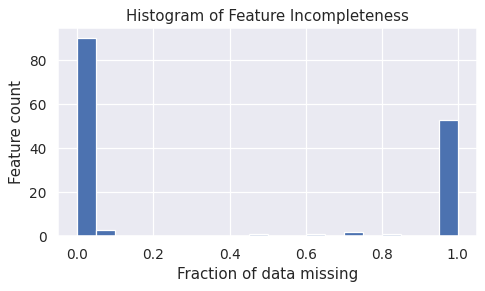

In [ ]:
plt.figure(figsize=(6,3), dpi=90)
missing_fractions.plot.hist(bins=20)
plt.title('Histogram of Feature Incompleteness')
plt.xlabel('Fraction of data missing')
plt.ylabel('Feature count')

From the above histogram, we see there's a large gap between features missing "some" data (&lt;20%) and those missing "lots" of data (&gt;40%). Because it's generally very difficult to accurately impute data with more than 30% missing values, we drop such columns. First store all variables missing more than 30% data in an alphabetical list:

In [ ]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

How many features will be dropped?

In [ ]:
len(drop_list)

58

Drop these features:

In [ ]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [ ]:
loans.shape

(175421, 93)

## 4.2 Only keep loan features known to potential investors
<a id="4.2"></a>

We examine the LendingClub website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features we currently have, in alphabetical order:

In [ ]:
print(sorted(loans.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

For each of these features, we check the description in the Data Dictionary and only keep the features that would have been available to investors considering an investment in the loan. These include features in the loan application, and any features added by LendingClub when the loan listing was accepted, such as the loan grade and interest rate.

I'm using my best available knowledge to determine which loan features are known to potential investors. I am not an investor on LendingClub, so my knowledge of the LendingClub investment process is not exact. When in doubt, I err on the side of dropping the feature.

In [ ]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code']

In [ ]:
len(keep_list)

31

The list of features to drop is any feature not in `keep_list`:

In [ ]:
drop_list = [col for col in loans.columns if col not in keep_list]
print(drop_list)

['funded_amnt', 'funded_amnt_inv', 'pymnt_plan', 'url', 'delinq_2yrs', 'inq_last_6mths', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc

In [ ]:
len(drop_list)

62

Drop these features:

In [ ]:
loans.drop(labels=drop_list, axis=1, inplace=True)

In [ ]:
loans.shape

(175421, 31)

In [ ]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175421 entries, 0 to 199998
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    175421 non-null  int64  
 1   loan_amnt             175421 non-null  float64
 2   term                  175421 non-null  object 
 3   int_rate              175421 non-null  float64
 4   installment           175421 non-null  float64
 5   grade                 175421 non-null  object 
 6   sub_grade             175421 non-null  object 
 7   emp_title             166394 non-null  object 
 8   emp_length            166404 non-null  object 
 9   home_ownership        175421 non-null  object 
 10  annual_inc            175421 non-null  float64
 11  verification_status   175421 non-null  object 
 12  issue_d               175421 non-null  object 
 13  loan_status           175421 non-null  object 
 14  purpose               175421 non-null  object 
 15  

# 5. Pre-processing and Exploratory Analysis
<a id="5"></a>

We'll inspect each feature individually, and do the following:

1. Drop the feature if it is not useful for predicting the loan status.
2. View summary statistics and visualize the data, plotting against the loan status.
3. Modify the feature to make it useful for modeling, if necessary.

We define a function for plotting a variable and comparing with the loan status:

In [ ]:
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with and without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True if the variable is continuous, False otherwise
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)

    # Plot without loan status
    if continuous:
        sns.distplot(loans.loc[loans[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        non_null_values = loans[col_name].dropna().unique()
        order_list = sorted(non_null_values)
        # Plot with the created order list
        sns.countplot(data=loans, x=col_name, order=order_list, color='#5975A4', saturation=1, ax=ax1)


    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=loans, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = loans.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)

    plt.tight_layout()

Print the remaining features for future reference:

In [ ]:
print(list(loans.columns))

['id', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'application_type', 'mort_acc', 'pub_rec_bankruptcies']


## 5.1 id

Data Dictionary: "A unique [LendingClub] assigned ID for the loan listing."

In [ ]:
loans['id'].sample(5)

30378     33601857
26681     34513125
132095    19587798
1942      37710498
109497    22231429
Name: id, dtype: int64

Are all the IDs unique?

In [ ]:
# loans['id'].describe()

# Assuming 'loans' is your DataFrame
unique_id_count = loans['id'].nunique()

# Alternatively, you can use the unique() method to get the unique values directly
unique_ids = loans['id'].unique()

# Check if the count of unique IDs is equal to the total number of rows
total_rows = len(loans)

if unique_id_count == total_rows:
    print("All 'id' values are unique.")
else:
    print("There are duplicate 'id' values.")


All 'id' values are unique.


Yes, they are all unique. The ID is not useful for modeling, either as a categorical variable (there are too many distinct values) or as a numerical variable (the IDs vary wildly in magnitude, likely without any significance), so we drop this variable.

In [ ]:
loans.drop('id', axis=1, inplace=True)

## 5.2 loan_amnt

Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [ ]:
loans['loan_amnt'].describe()

count    175421.000000
mean      14159.529788
std        8364.416083
min        1000.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

Loan amounts range from \$1000 to \$35,000, with a median of \$12,000.

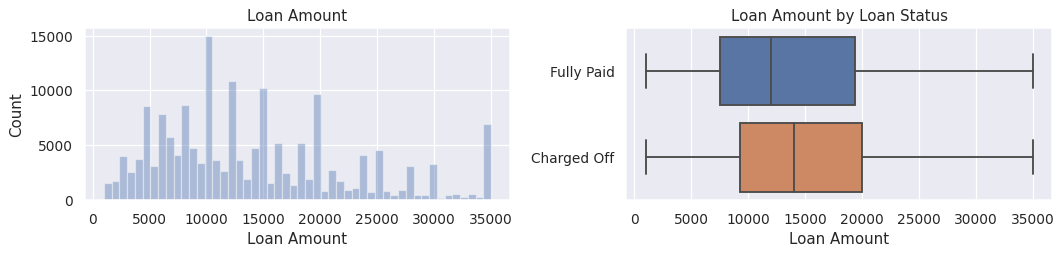

In [ ]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

Charged-off loans tend to have higher loan amounts. Let's compare the summary statistics by loan status:

In [ ]:
loans.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,15298.158515,8365.163736,1000.0,9250.0,14000.0,20000.0,35000.0
Fully Paid,142730.0,13898.737301,8342.428948,1000.0,7500.0,12000.0,19350.0,35000.0


## 5.3 term

Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

In [ ]:
loans['term'].value_counts(dropna=False)

 36 months    135928
 60 months     39493
Name: term, dtype: int64

Convert `term` to integers.

In [ ]:
loans['term'] = loans['term'].apply(lambda s: np.int8(s.split()[0]))

In [ ]:
loans['term'].value_counts(normalize=True)

36    0.774867
60    0.225133
Name: term, dtype: float64

Compare the charge-off rate by loan period:

In [ ]:
loans.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.138684
60    0.350442
Name: loan_status, dtype: float64

About 76% of the completed loans have three-year periods, and the rest have five-year periods. Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.

## 5.4 int_rate  Step for Data Understanding .


Data Dictionary: "Interest Rate on the loan."

In [ ]:
loans['int_rate'].describe()

count    175421.000000
mean         13.395569
std           4.330604
min           6.000000
25%          10.150000
50%          12.990000
75%          15.610000
max          26.060000
Name: int_rate, dtype: float64

In [ ]:
loans['int_rate'] = loans['int_rate'].apply(lambda s: float(s.replace('%', '')) if isinstance(s, str) else s)

Interest rates range from 6.00% to 26.06% (!) with a median of 12.9%.

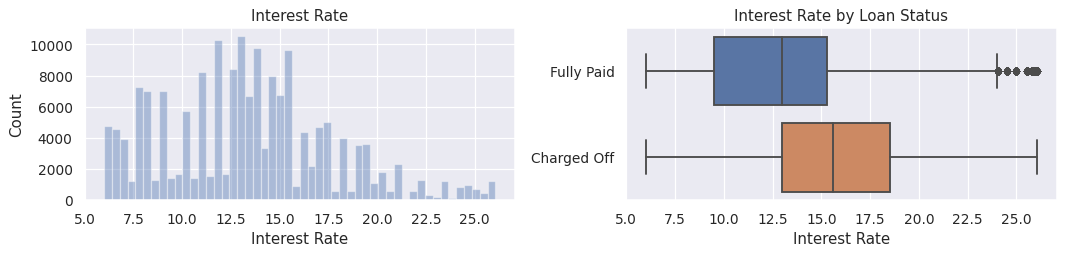

In [ ]:
plot_var('int_rate', 'Interest Rate', continuous=True)

Charged-off loans tend to have much higher interest rates. Let's compare the summary statistics by loan status:

In [ ]:
loans.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,15.819228,4.252901,6.0,12.99,15.59,18.54,26.06
Fully Paid,142730.0,12.840453,4.153726,6.0,9.49,12.99,15.31,26.06


## 5.5 installment

Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [ ]:
loans['installment'].describe()

count    175421.000000
mean        433.309001
std         250.062811
min          23.360000
25%         251.560000
50%         373.220000
75%         570.840000
max        1409.990000
Name: installment, dtype: float64

Installments range from \$4.93 to \$1,714, with a median of \$377.

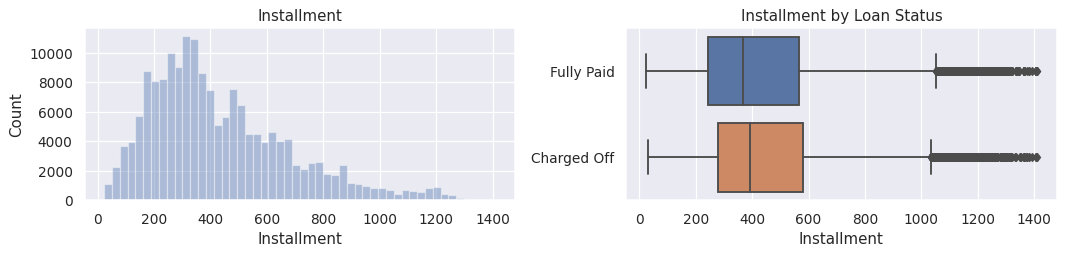

In [ ]:
plot_var('installment', 'Installment', continuous=True)

Charged-off loans tend to have higher installments. Let's compare the summary statistics by loan status:

In [ ]:
loans.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,450.669499,239.545709,30.44,278.54,394.13,580.435,1408.13
Fully Paid,142730.0,429.332738,252.242681,23.36,245.16,367.74,568.010,1409.99


Loans that charge off have \$30 higher installments on average.

## 5.6 grade, sub_grade

Data Dictionary for `grade`: "LendingClub assigned loan grade."

Data Dictionary for `sub_grade`: "LendingClub assigned loan subgrade."

What are the possible values of `grade` and `sub_grade`?

In [ ]:
print(sorted(loans['grade'].unique()))

['A', 'B', 'C', 'D', 'E', 'F', 'G']


In [ ]:
print(sorted(loans['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The grade is implied by the subgrade, so let's drop the grade column.

In [ ]:
loans.drop('grade', axis=1, inplace=True)

In [ ]:
loans['sub_grade'] = loans['sub_grade'].astype('object')

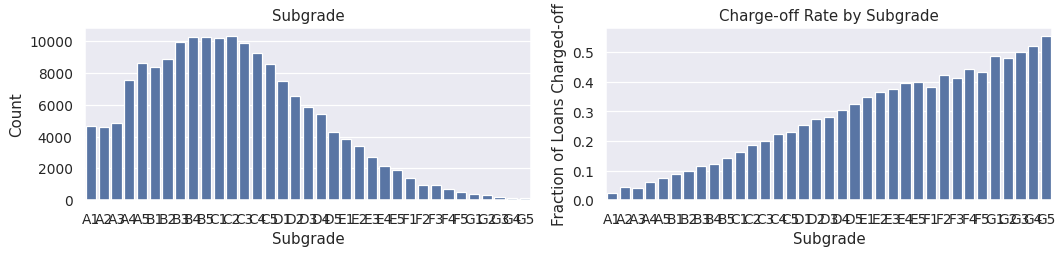

In [ ]:
plot_var('sub_grade', 'Subgrade', continuous=False)

There's a clear trend of higher probability of charge-off as the subgrade worsens.

## 5.7 emp_title

Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [ ]:
loans['emp_title'].describe()
# loans['emp_title'].unique()

count      166394
unique      59349
top       Teacher
freq         3279
Name: emp_title, dtype: object

There are too many different job titles for this feature to be useful, so we drop it.

In [ ]:
loans.drop(labels='emp_title', axis=1, inplace=True)

## 5.8 emp_length

Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [ ]:
loans['emp_length'].value_counts(dropna=False).sort_index()

1 year       11174
10+ years    57590
2 years      15556
3 years      13793
4 years      10371
5 years       9612
6 years       8799
7 years       9711
8 years       8907
9 years       7103
< 1 year     13788
NaN           9017
Name: emp_length, dtype: int64

Note there are 42,253 loans without data on the length of employment.

Convert `emp_length` to integers:

In [ ]:
loans['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

In [ ]:
loans['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [ ]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [ ]:
loans['emp_length'] = loans['emp_length'].apply(emp_length_to_int)

In [ ]:
loans['emp_length'].value_counts(dropna=False).sort_index()

0.0     13788
1.0     11174
2.0     15556
3.0     13793
4.0     10371
5.0      9612
6.0      8799
7.0      9711
8.0      8907
9.0      7103
10.0    57590
NaN      9017
Name: emp_length, dtype: int64

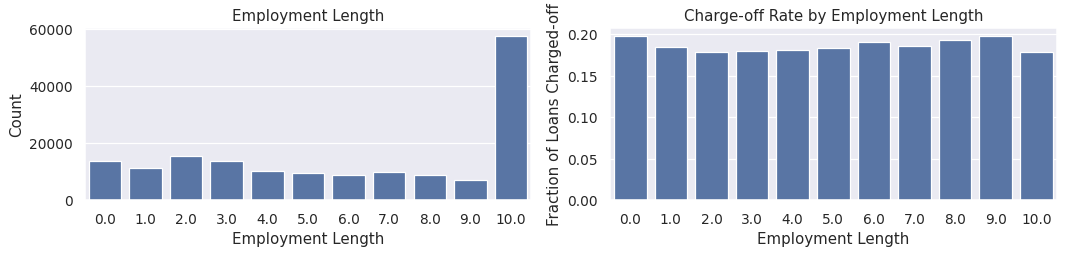

In [ ]:
plot_var('emp_length', 'Employment Length', continuous=False)

Loan status does not appear to vary much with employment length on average, except for a small drop in charge-offs for borrowers with over 10 years of employment.

## 5.9 home_ownership

Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

In [ ]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    86633
RENT        71430
OWN         17357
ANY             1
Name: home_ownership, dtype: int64

Replace the values `ANY` and `NONE` with `OTHER`:

In [ ]:
loans['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [ ]:
loans['home_ownership'].value_counts(dropna=False)

MORTGAGE    86633
RENT        71430
OWN         17357
OTHER           1
Name: home_ownership, dtype: int64

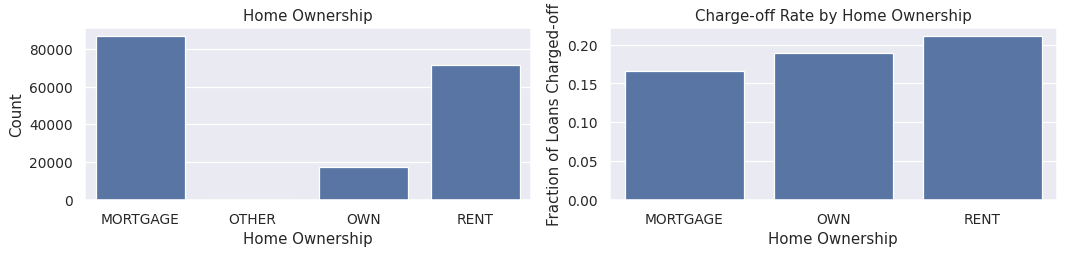

In [ ]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

There appear to be large differences in charge-off rates by home ownership status. Renters and homeowners have a higher probability of charge-off. Let's compare the charge-off rates:

In [ ]:
loans.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.165676
OWN         0.188742
RENT        0.210864
Name: loan_status, dtype: float64

## 5.10 annual_inc

Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [ ]:
loans['annual_inc'].describe()

count    1.754210e+05
mean     7.397439e+04
std      5.393443e+04
min      3.000000e+03
25%      4.500000e+04
50%      6.300000e+04
75%      9.000000e+04
max      7.500000e+06
Name: annual_inc, dtype: float64

Annual income ranges from \$0 to \$9,550,000, with a median of \$65,000. Because of the large range of incomes, we should take a log transform of the annual income variable.

In [ ]:
loans['log_annual_inc'] = loans['annual_inc'].apply(lambda x: np.log10(x+1))

In [ ]:
loans.drop('annual_inc', axis=1, inplace=True)

In [ ]:
loans['log_annual_inc'].describe()

count    175421.000000
mean          4.804152
std           0.230515
min           3.477266
25%           4.653222
50%           4.799347
75%           4.954247
max           6.875061
Name: log_annual_inc, dtype: float64

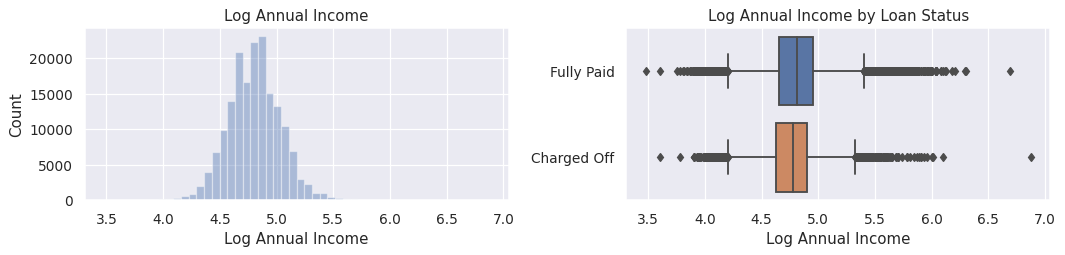

In [ ]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

It appears that individuals with higher income are more likely to pay off their loans. Let's compare the summary statistics by loan status:

In [ ]:
loans.groupby('loan_status')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,4.770070,0.220750,3.602169,4.623260,4.778064,4.903095,6.875061
Fully Paid,142730.0,4.811958,0.231991,3.477266,4.653222,4.812920,4.954247,6.690196


## 5.11 verification_status

Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

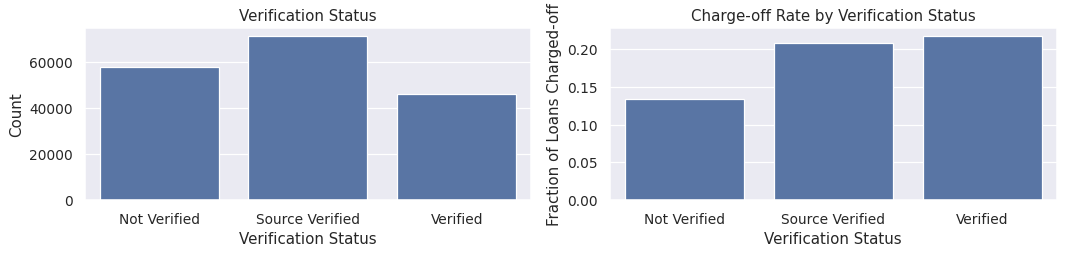

In [ ]:
plot_var('verification_status', 'Verification Status', continuous=False)

## 5.12 issue_d

Data Dictionary: "The month which the loan was funded."

Because we're only using variables available to investors before the loan was funded, `issue_d` will not be included in the final model. We're keeping it for now just to perform the train/test split later, then we'll drop it.

## 5.13 purpose

Data Dictionary: "A category provided by the borrower for the loan request."

In [ ]:
loans['purpose'].value_counts()

debt_consolidation    106366
credit_card            40094
home_improvement        9893
other                   8317
major_purchase          3019
medical                 1823
small_business          1631
car                     1468
moving                  1119
vacation                 996
house                    592
renewable_energy          96
wedding                    7
Name: purpose, dtype: int64

Calculate the charge-off rates by purpose:

In [ ]:
loans.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

purpose
car                   0.138283
credit_card           0.157904
home_improvement      0.165471
major_purchase        0.173236
vacation              0.177711
other                 0.189612
medical               0.195283
debt_consolidation    0.197432
renewable_energy      0.218750
house                 0.224662
moving                0.246649
small_business        0.280196
Name: loan_status, dtype: float64

Notice that only 12% of completed loans for weddings have charged-off, but 30% of completed small business loans have charged-off.

## 5.14 title

Data Dictionary: "The loan title provided by the borrower."

In [ ]:
loans['title'].describe()

count                 175421
unique                    33
top       Debt consolidation
freq                  106416
Name: title, dtype: object

View the top 10 loan titles, and their frequencies:

In [ ]:
loans['title'].value_counts().head(10)

Debt consolidation         106416
Credit card refinancing     40027
Home improvement             9897
Other                        8310
Major purchase               3013
Medical expenses             1827
Business                     1630
Car financing                1471
Moving and relocation        1122
Vacation                      993
Name: title, dtype: int64

There are 60,298 different titles in the dataset, and based on the top 10 titles, the `purpose` variable appears to already contain this information. So we drop the `title` variable.

In [ ]:
loans.drop('title', axis=1, inplace=True)

## 5.15 zip_code, addr_state

Data Dictionary for `zip_code`: "The first 3 numbers of the zip code provided by the borrower in the loan application."

Data Dictionary for `addr_state`: "The state provided by the borrower in the loan application."

In [ ]:
loans['zip_code'].sample(5)

37470     070xx
166511    315xx
25392     553xx
70622     300xx
153098    708xx
Name: zip_code, dtype: object

In [ ]:
loans['zip_code'].nunique()

860

In [ ]:
loans['addr_state'].sample(5)

152640    GA
51058     CO
30807     PA
183283    LA
61347     IL
Name: addr_state, dtype: object

In [ ]:
loans['addr_state'].nunique()

47

There are a lot of different zip codes, so let's just keep the state column.

In [ ]:
loans.drop(labels='zip_code', axis=1, inplace=True)

Calculate the charge-off rates by address state:

In [ ]:
loans.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

addr_state
DC    0.124000
NH    0.128878
VT    0.141791
KS    0.144275
OR    0.144895
CO    0.147849
WA    0.150724
CT    0.155547
SC    0.158166
WV    0.161036
IL    0.163110
WI    0.166880
WY    0.170561
UT    0.172387
GA    0.172737
MT    0.175407
CA    0.178629
TX    0.179055
MA    0.181701
AZ    0.183488
AK    0.185780
MI    0.186452
NJ    0.186726
RI    0.188557
SD    0.190104
MD    0.190115
NC    0.192242
MN    0.193095
OH    0.195034
FL    0.197481
VA    0.198696
IN    0.200263
KY    0.201397
NY    0.204441
NM    0.205205
HI    0.205618
PA    0.206992
MO    0.208514
AR    0.210884
LA    0.212211
NV    0.216293
TN    0.217131
AL    0.225333
OK    0.226512
DE    0.226531
MS    0.237186
Name: loan_status, dtype: float64

The charge-off rate ranges from 13.0% in Washington, DC to 27.6% in Mississippi.

## 5.16 dti

Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."

In [ ]:
loans['dti'].describe()

count    175421.000000
mean         17.928268
std           8.095209
min           0.000000
25%          11.850000
50%          17.460000
75%          23.660000
max          39.990000
Name: dti, dtype: float64

Note sure if the values of -1 and 999 make sense...

There are several outliers that mess up our default plots. Plot a histogram for `dti` less than 60:

Text(0.5, 1.0, 'Debt-to-income Ratio')

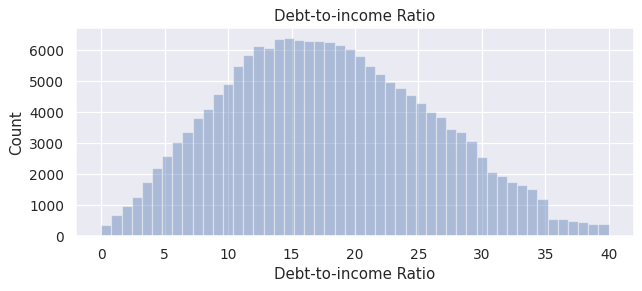

In [ ]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(loans.loc[loans['dti'].notnull() & (loans['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

How many of the `dti` values are "outliers" (above 60)?

In [ ]:
(loans['dti']>=60).sum()

0

Very few. Compare the summary statistics by loan status:

In [ ]:
loans.groupby('loan_status')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,19.744853,8.185955,0.0,13.68,19.60,25.74,39.99
Fully Paid,142730.0,17.512195,8.016578,0.0,11.50,16.99,23.14,39.99


Completed loans that are charged off tend to have higher debt-to-income ratios.

## 5.17 earliest_cr_line

Data Dictionary: "The month the borrower's earliest reported credit line was opened."

In [ ]:
loans['earliest_cr_line'].sample(5)

116279    Sep-1978
171859    Dec-1989
3222      Dec-1979
178277    Jan-2001
20006     Feb-1976
Name: earliest_cr_line, dtype: object

In [ ]:
loans['earliest_cr_line'].isnull().any()

False

Let's just retain the year for simplicity:

In [ ]:
loans['earliest_cr_line'] = loans['earliest_cr_line'].apply(lambda s: int(str(s)[-4:]) if isinstance(s, str) else s)

In [ ]:
loans['earliest_cr_line'].describe()

count    175421.000000
mean       1997.632039
std           7.459418
min        1944.000000
25%        1994.000000
50%        1999.000000
75%        2003.000000
max        2011.000000
Name: earliest_cr_line, dtype: float64

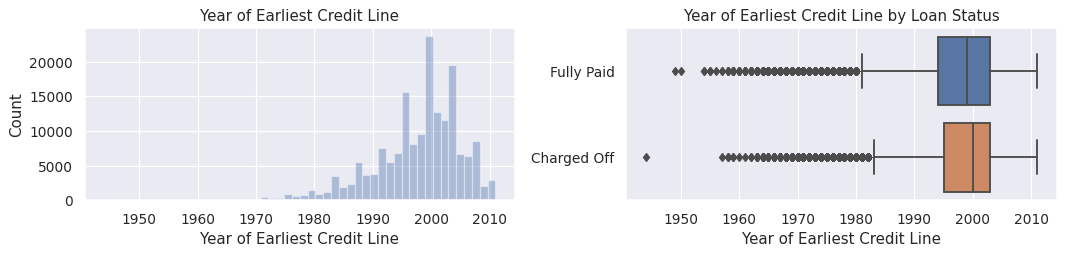

In [ ]:
plot_var('earliest_cr_line', 'Year of Earliest Credit Line', continuous=True)

Borrowers who are charged-off tend to have shorter lines of credit.

## 5.18 fico_range_low, fico_range_high

Data Dictionary for `fico_range_low`: "The lower boundary range the borrower’s FICO at loan origination belongs to."

Data Dictionary for `fico_range_high`: "The upper boundary range the borrower’s FICO at loan origination belongs to."

In [ ]:
loans[['fico_range_low', 'fico_range_high']].describe()

,fico_range_low,fico_range_high
count,175421.000000,175421.000000
mean,692.539348,696.539405
std,29.630372,29.630666
min,660.000000,664.000000
25%,670.000000,674.000000
50%,685.000000,689.000000
75%,705.000000,709.000000
max,845.000000,850.000000


Check the Pearson correlation between these values:

In [ ]:
loans[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


We only need to keep one of the FICO scores. We'll take the average of the two and call it `fico_score`:

In [ ]:
loans['fico_score'] = 0.5*loans['fico_range_low'] + 0.5*loans['fico_range_high']

In [ ]:
loans.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

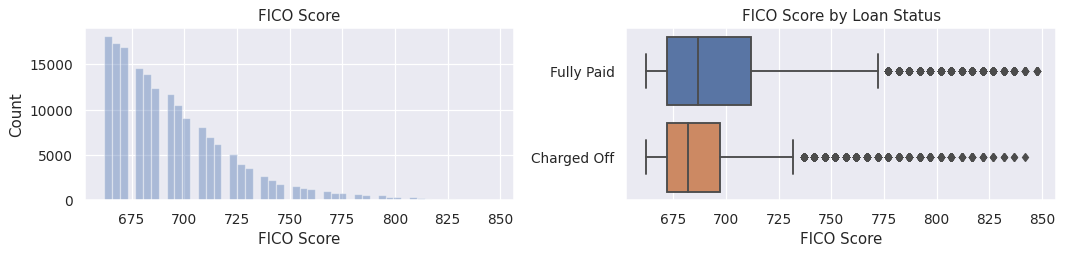

In [ ]:
plot_var('fico_score', 'FICO Score', continuous=True)

There is a noticeable difference in FICO scores between fully paid and charged-off loans. Compare the summary statistics:

In [ ]:
loans.groupby('loan_status')['fico_score'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,687.288306,23.659185,662.0,672.0,682.0,697.0,842.0
Fully Paid,142730.0,696.200168,30.595007,662.0,672.0,687.0,712.0,847.5


Loans that charge off have a FICO score 10 points lower on average.

## 5.19 open_acc

Data Dictionary: "The number of open credit lines in the borrower's credit file."

Text(0.5, 1.0, 'Number of Open Credit Lines')

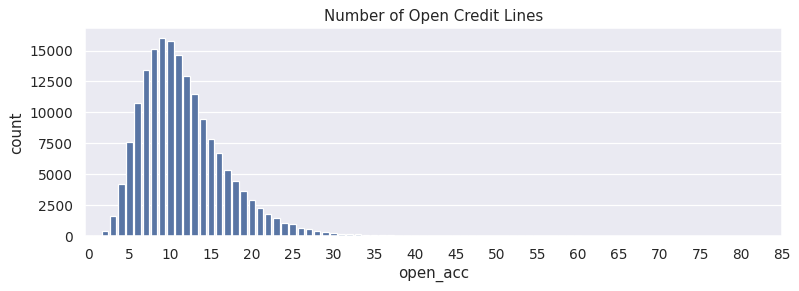

In [ ]:
plt.figure(figsize=(10,3), dpi=90)
sns.countplot(data= loans,x='open_acc', order=sorted(loans['open_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
plt.title('Number of Open Credit Lines')

Is there a difference in number of credit lines between fully paid loans and charged-off loans?

In [ ]:
loans.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,11.958857,5.426800,0.0,8.0,11.0,15.0,76.0
Fully Paid,142730.0,11.541323,5.257441,1.0,8.0,11.0,14.0,84.0


## 5.20 pub_rec

Data Dictionary: "Number of derogatory public records."

In [ ]:
loans['pub_rec'].value_counts().sort_index()

0.0     144022
1.0      26352
2.0       3387
3.0       1005
4.0        323
5.0        164
6.0         82
7.0         38
8.0         16
9.0         10
10.0         9
11.0         5
12.0         2
15.0         1
16.0         1
18.0         2
19.0         1
40.0         1
Name: pub_rec, dtype: int64

Is there a difference in average public records between fully paid loans and charged-off loans?

In [ ]:
loans.groupby('loan_status')['pub_rec'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,0.235080,0.618033,0.0,0.0,0.0,0.0,40.0
Fully Paid,142730.0,0.223072,0.582017,0.0,0.0,0.0,0.0,18.0


## 5.21 revol_bal

Data Dictionary: "Total credit revolving balance."

In [ ]:
loans['revol_bal'].describe()

count    1.754210e+05
mean     1.602978e+04
std      2.165516e+04
min      0.000000e+00
25%      5.975000e+03
50%      1.108800e+04
75%      1.972600e+04
max      2.560703e+06
Name: revol_bal, dtype: float64

Do a log transform:

In [ ]:
loans['log_revol_bal'] = loans['revol_bal'].apply(lambda x: np.log10(x+1))

In [ ]:
loans.drop('revol_bal', axis=1, inplace=True)

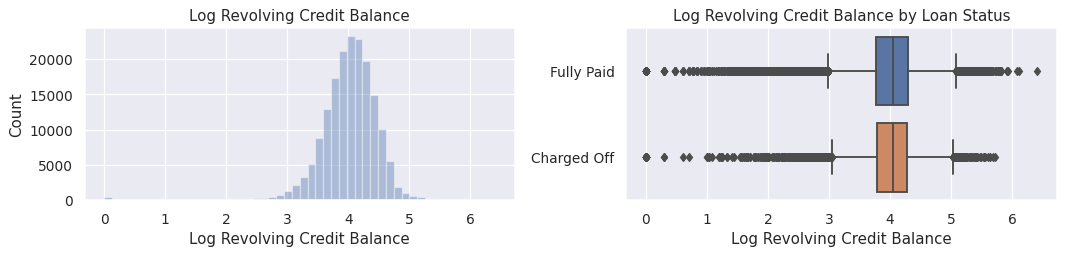

In [ ]:
plot_var('log_revol_bal', 'Log Revolving Credit Balance', continuous=True)

In [ ]:
loans.groupby('loan_status')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,4.005679,0.446377,0.0,3.786006,4.045127,4.281499,5.715439
Fully Paid,142730.0,4.011170,0.472218,0.0,3.774006,4.044794,4.298547,6.408359


There isn't a large difference in the means.

## 5.22 revol_util

Data Dictionary: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."

In [ ]:
loans['revol_util'].describe()

count    175329.000000
mean         54.677114
std          23.297539
min           0.000000
25%          37.600000
50%          55.100000
75%          72.400000
max         892.300000
Name: revol_util, dtype: float64

In [ ]:
loans['revol_util'] = loans['revol_util'].apply(lambda s: float(s.replace('%', '')) if isinstance(s, str) else s)

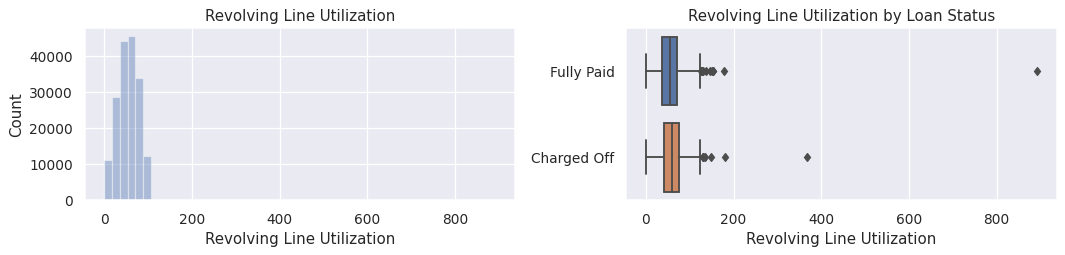

In [ ]:
plot_var('revol_util', 'Revolving Line Utilization', continuous=True)

In [ ]:
loans.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32669.0,57.746191,22.567358,0.0,41.9,58.6,75.0,366.6
Fully Paid,142660.0,53.974299,23.405065,0.0,36.7,54.2,71.8,892.3


## 5.23 total_acc

Data Dictionary: "The total number of credit lines currently in the borrower's credit file."

Text(0.5, 1.0, 'Total Number of Credit Lines')

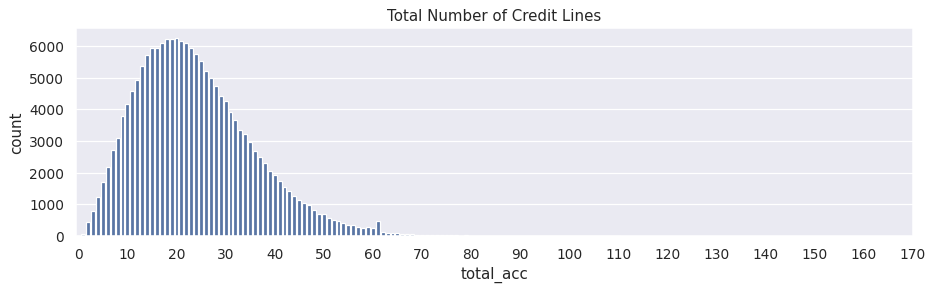

In [ ]:
plt.figure(figsize=(12,3), dpi=90)
sns.countplot(data = loans, x ='total_acc', order=sorted(loans['total_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 176, 10), np.arange(0, 176, 10))
plt.title('Total Number of Credit Lines')

In [ ]:
loans.groupby('loan_status')['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,25.767948,12.151543,2.0,17.0,24.0,33.0,119.0
Fully Paid,142730.0,25.879114,11.971974,2.0,17.0,24.0,33.0,156.0


No large differences here.

## 5.24 initial_list_status

Data Dictionary: "The initial listing status of the loan. Possible values are – W, F." I'm not sure what this means.

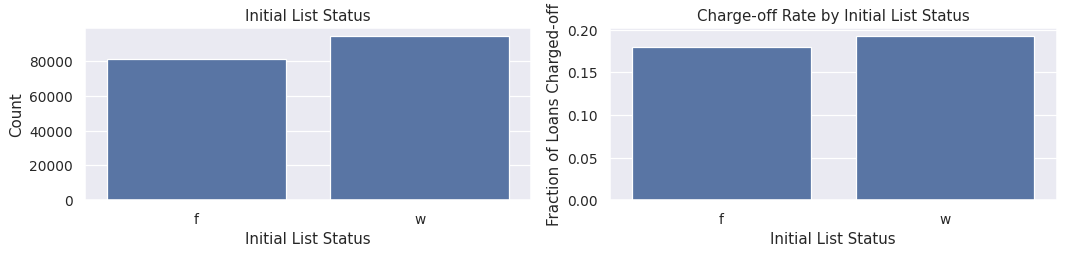

In [ ]:
plot_var('initial_list_status', 'Initial List Status', continuous=False)

## 5.25 application_type

Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

In [ ]:
loans['application_type'].value_counts()

Individual    175421
Name: application_type, dtype: int64

Let's just compare the charge-off rates by application type:

In [ ]:
loans.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

application_type
Individual    0.186357
Name: loan_status, dtype: float64

Joint loans are slightly less likely to be charged-off.

## 5.26 mort_acc

Data Dictionary: "Number of mortgage accounts."

In [ ]:
loans['mort_acc'].describe()

count    175421.000000
mean          1.794050
std           2.138689
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          34.000000
Name: mort_acc, dtype: float64

Not sure how someone can have 51 mortgage accounts...but apparently they do. Check the top 10 values:

In [ ]:
loans['mort_acc'].value_counts().head(10)

0.0    69936
1.0    28399
2.0    24302
3.0    18698
4.0    13879
5.0     8865
6.0     5329
7.0     2809
8.0     1474
9.0      735
Name: mort_acc, dtype: int64

Compare the summary statistics by loan status:

In [ ]:
loans.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,32691.0,1.538374,1.993969,0.0,0.0,1.0,3.0,22.0
Fully Paid,142730.0,1.852610,2.166241,0.0,0.0,1.0,3.0,34.0


Individuals who pay off their loans are more likely to have several mortgage accounts.

## 5.27 pub_rec_bankruptcies

Data Dictionary: "Number of public record bankruptcies."

In [ ]:
loans['pub_rec_bankruptcies'].value_counts().sort_index()

0.0     152700
1.0      21397
2.0       1025
3.0        224
4.0         49
5.0         18
6.0          2
7.0          5
12.0         1
Name: pub_rec_bankruptcies, dtype: int64

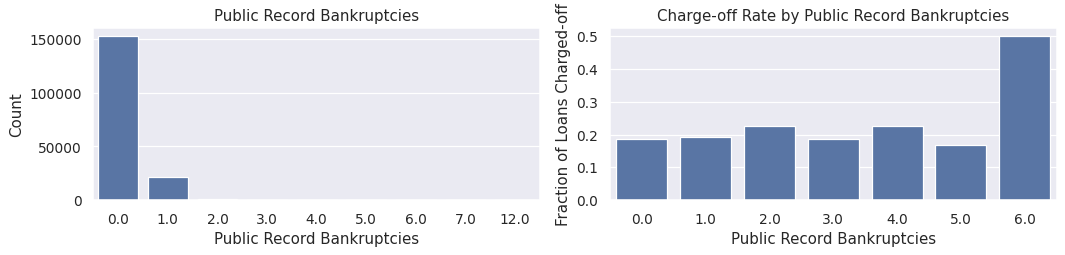

In [ ]:
plot_var('pub_rec_bankruptcies', 'Public Record Bankruptcies', continuous=False)

# 6. More Pre-processing
<a id="6"></a>

## 6.1 Convert loan status to 0/1 charge-off indicator
<a id="6.1"></a>

Change the response variable `loan_status` to a 0/1 variable, where 0 indicates fully paid and 1 indicates charge-off:

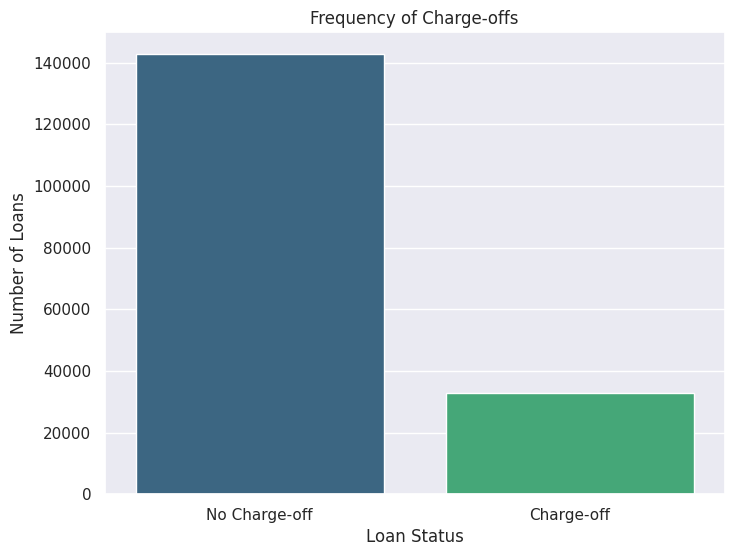

In [ ]:
# Example Data for Charge-offs
charge_off_data = loans['loan_status'] == 'Charged Off'  # Simulating charge-off data (0 or 1)

# Visualization 1: Bar Chart - Frequency of Charge-offs
charge_off_counts = np.bincount(charge_off_data)
labels = ['No Charge-off', 'Charge-off']
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=charge_off_counts, palette='viridis')
plt.title('Frequency of Charge-offs')
plt.xlabel('Loan Status')
plt.ylabel('Number of Loans')
plt.show()


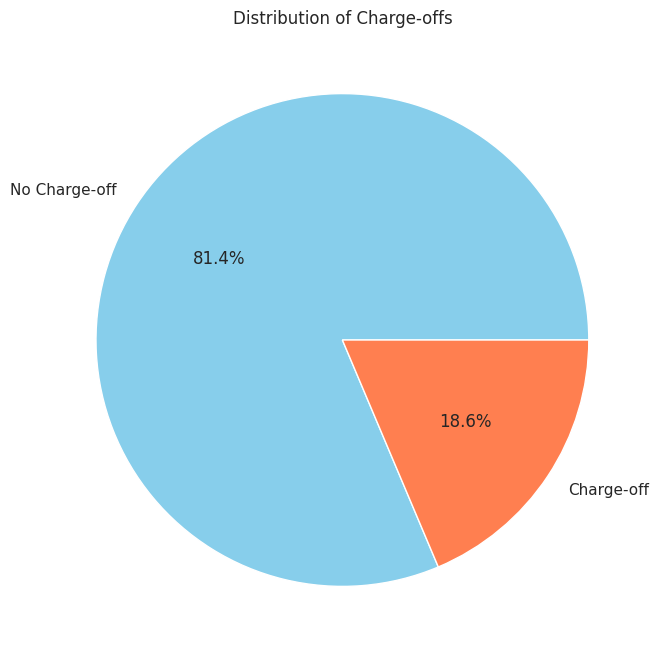

In [ ]:
# Visualization 2: Pie Chart - Distribution of Charge-offs
plt.figure(figsize=(8, 8))
plt.pie(charge_off_counts, labels=labels, autopct='%1.1f%%', colors=['skyblue', 'coral'])
plt.title('Distribution of Charge-offs')
plt.show()

In [ ]:
loans['charged_off'] = (loans['loan_status'] == 'Charged Off').apply(np.uint8)
loans.drop('loan_status', axis=1, inplace=True)

In [ ]:
loans.sample(5)

,loan_amnt,term,int_rate,installment,sub_grade,emp_length,home_ownership,verification_status,issue_d,purpose,addr_state,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off
160411,9600.0,36,8.39,302.56,A5,3.0,MORTGAGE,Not Verified,May-2014,debt_consolidation,GA,9.25,2003,14.0,0.0,27.0,31.0,w,Individual,2.0,0.0,4.944488,717.0,4.063333,0
42655,25000.0,36,7.69,779.84,A4,10.0,MORTGAGE,Source Verified,Oct-2014,debt_consolidation,MS,12.24,1984,7.0,1.0,85.6,14.0,f,Individual,2.0,1.0,4.838855,687.0,4.015318,0
152897,9000.0,36,10.15,291.04,B2,2.0,RENT,Not Verified,May-2014,home_improvement,FL,22.04,1997,25.0,0.0,42.2,51.0,f,Individual,4.0,0.0,4.832515,672.0,4.072103,0
180999,15900.0,60,25.80,474.18,G1,8.0,MORTGAGE,Verified,Apr-2014,debt_consolidation,MI,16.52,1985,11.0,1.0,75.0,42.0,w,Individual,6.0,1.0,4.778158,662.0,4.402605,0
69100,8400.0,36,11.67,277.68,B4,4.0,MORTGAGE,Not Verified,Oct-2014,debt_consolidation,NC,13.62,1996,9.0,0.0,95.3,18.0,w,Individual,1.0,0.0,5.033428,682.0,3.882354,0


In [ ]:
len(loans.columns)

25

## 6.2 Create dummy variables
<a id="6.2"></a>

How many variables do we currently have?

In [ ]:
loans.shape

(175421, 25)

If any categorical variables have missing values, we'll need to create NaN dummy variables for those. So first check which variables have missing data:

In [ ]:
missing_fractions = loans.isnull().mean().sort_values(ascending=False) # Fraction of data missing for each variable

In [ ]:
print(missing_fractions[missing_fractions > 0]) # Print variables that are missing data

emp_length    0.051402
revol_util    0.000524
dtype: float64


There are no categorical variables with missing values, and therefore we don't need any `NaN` dummy variables.

Create dummy variables for the categorical variables:

In [ ]:
print(loans.columns)

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade',
       'emp_length', 'home_ownership', 'verification_status', 'issue_d',
       'purpose', 'addr_state', 'dti', 'earliest_cr_line', 'open_acc',
       'pub_rec', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies',
       'log_annual_inc', 'fico_score', 'log_revol_bal', 'charged_off'],
      dtype='object')


In [ ]:
loans = pd.get_dummies(loans, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

How many variables are there now?

In [ ]:
loans.shape

(175421, 116)

Check our data with the new dummy variables:

In [ ]:
loans.sample(5)

,loan_amnt,term,int_rate,installment,emp_length,issue_d,dti,earliest_cr_line,open_acc,pub_rec,revol_util,total_acc,mort_acc,pub_rec_bankruptcies,log_annual_inc,fico_score,log_revol_bal,charged_off,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_w
52753,21250.0,36,14.99,736.54,2.0,Oct-2014,12.43,1999,9.0,0.0,51.3,27.0,0.0,0.0,4.698979,702.0,3.833657,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
98384,9725.0,36,18.99,356.44,10.0,Aug-2014,14.76,2001,8.0,0.0,95.9,15.0,2.0,0.0,4.698979,672.0,4.046300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
37650,15350.0,36,22.15,587.42,0.0,Nov-2014,13.42,2009,15.0,0.0,81.4,20.0,0.0,0.0,4.732402,677.0,3.936413,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
151160,8400.0,36,13.35,284.45,10.0,May-2014,10.86,2000,9.0,0.0,70.4,21.0,4.0,0.0,4.903095,662.0,3.847573,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
32953,14400.0,60,18.99,373.47,2.0,Oct-2014,20.52,2003,12.0,1.0,12.5,24.0,3.0,1.0,4.778158,727.0,3.382737,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


## 6.3 Train/test split
<a id="6.3"></a>

We'll make our modeling problem more realistic by performing the train/test split based on the month that the loan was funded. That is, we'll use loans funded on earlier dates to predict whether future loans will charge-off. The variable `issue_d` includes the month and year that the loan was funded.

In [ ]:
loans['issue_d'].sample(5)

181564    Apr-2014
159564    May-2014
174507    Apr-2014
199074    Mar-2014
144671    Jun-2014
Name: issue_d, dtype: object

Are there any missing values?

In [ ]:
loans['issue_d'].isnull().any()

False

No. Let's convert the issue dates to datetime objects:

In [ ]:
loans['issue_d'] = pd.to_datetime(loans['issue_d'])

In [ ]:
loans['issue_d'].sample(5)

41117    2014-10-01
156085   2014-05-01
85337    2014-08-01
153815   2014-05-01
191306   2014-03-01
Name: issue_d, dtype: datetime64[ns]

The new datetime values are all on the first day of the month. Check the summary statistics of the issue dates:

In [ ]:
loans['issue_d'].describe()

count                  175421
unique                     10
top       2014-10-01 00:00:00
freq                    33699
first     2014-03-01 00:00:00
last      2014-12-01 00:00:00
Name: issue_d, dtype: object

There are only 124 unique issue dates over the 1-year period because we only have month/year information. In this particular dataset, the first loans were issued in Apr 2014, and the most recent loans were issued in Dec 2014.

Text(0.5, 1.0, 'Loans Funded per Year')

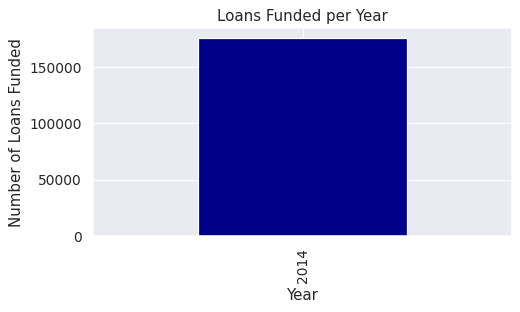

In [ ]:
plt.figure(figsize=(6,3), dpi=90)
loans['issue_d'].dt.year.value_counts().sort_index().plot.bar(color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Loans Funded')
plt.title('Loans Funded per Year')

We'll form the test set from the most recent 10% of the loans.

In [ ]:
loans_train = loans.loc[loans['issue_d'] <  loans['issue_d'].quantile(0.9)]
loans_test =  loans.loc[loans['issue_d'] >= loans['issue_d'].quantile(0.9)]

Check that we properly partitioned the loans:

In [ ]:
print('Number of loans in the partition:   ', loans_train.shape[0] + loans_test.shape[0])
print('Number of loans in the full dataset:', loans.shape[0])

Number of loans in the partition:    175421
Number of loans in the full dataset: 175421


What is the test size?

In [ ]:
loans_test.shape[0] / loans.shape[0]

0.16799014941198603

The partition looks good, so we can delete the original `loans` dataframe:

In [ ]:
del loans

Let's look at the summary statistics of the issue dates in the train and test sets:

In [ ]:
loans_train['issue_d'].describe()

count                  145952
unique                      8
top       2014-10-01 00:00:00
freq                    33699
first     2014-03-01 00:00:00
last      2014-10-01 00:00:00
Name: issue_d, dtype: object

In [ ]:
loans_test['issue_d'].describe()

count                   29469
unique                      2
top       2014-11-01 00:00:00
freq                    21186
first     2014-11-01 00:00:00
last      2014-12-01 00:00:00
Name: issue_d, dtype: object

The training set includes loans from March 2014 to October 2014. The test set includes loans from November 2014 to December 2014.

Now we need to delete the `issue_d` variable, because it was not available before the loan was funded.

In [ ]:
loans_train.drop('issue_d', axis=1, inplace=True)
loans_test.drop('issue_d', axis=1, inplace=True)

Now separate the predictor variables from the response variable:
Because the input dataset is really big,  I only take 10% DATA for training.  You can use 100% data.

In [ ]:
subsetloans_train=loans_train.sample(frac=1)

#y_train = loans_train['charged_off']
y_train = subsetloans_train['charged_off']

y_test = loans_test['charged_off']

In [ ]:
#X_train = loans_train.drop('charged_off', axis=1)
X_train = subsetloans_train.drop('charged_off', axis=1)
X_test = loans_test.drop('charged_off', axis=1)

In [ ]:
del loans_train, loans_test

In [ ]:
!pip install -U imbalanced-learn

In [ ]:
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming X_train, y_train are your training data and labels
# Assuming X_test, y_test are your testing data and labels

# Define your imbalanced-learn pipeline with SMOTE and an MLPClassifier
pipeline_nn_smote = Pipeline([
    ('imputer', SimpleImputer(copy=False)),  # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('smote', SMOTE(random_state=42)),  # Add SMOTE for upsampling
    ('model', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42))  # Customize the MLPClassifier parameters here
])

# Fit the pipeline on the training data
pipeline_nn_smote.fit(X_train, y_train)

# Make predictions on the test data
y_pred_smote = pipeline_nn_smote.predict(X_test)

# Calculate accuracy
accuracy_smote = accuracy_score(y_test, y_pred_smote)
print(f'Accuracy with SMOTE: {accuracy_smote}')


Accuracy with SMOTE: 0.7612406257423054


# 7. Linear Dependence of Charge-off on the Predictors
<a id="7"></a>

On the training set, we compute the Pearson correlation, F-statistics and $p$ value of each predictor with the response variable `charged_off`.

In [ ]:
linear_dep = pd.DataFrame()

Pearson correlations:

In [ ]:
for col in X_train.columns:
    linear_dep.loc[col, 'pearson_corr'] = X_train[col].corr(y_train)
linear_dep['abs_pearson_corr'] = abs(linear_dep['pearson_corr'])

linear_dep

,pearson_corr,abs_pearson_corr
loan_amnt,0.065388,0.065388
term,0.228918,0.228918
int_rate,0.265011,0.265011
installment,0.032527,0.032527
emp_length,-0.006181,0.006181
dti,0.105260,0.105260
earliest_cr_line,0.038822,0.038822
open_acc,0.028224,0.028224
pub_rec,0.007632,0.007632
revol_util,0.062338,0.062338


$F$-statistics:

In [ ]:
from sklearn.feature_selection import f_classif
for col in X_train.columns:
    mask = X_train[col].notnull()
    (linear_dep.loc[col, 'F'], linear_dep.loc[col, 'p_value']) = f_classif(pd.DataFrame(X_train.loc[mask, col]), y_train.loc[mask])

Sort the results by the absolute value of the Pearson correlation:

In [ ]:
linear_dep.sort_values('abs_pearson_corr', ascending=False, inplace=True)
linear_dep.drop('abs_pearson_corr', axis=1, inplace=True)

Reset the index:

In [ ]:
linear_dep.reset_index(inplace=True)
linear_dep.rename(columns={'index':'variable'}, inplace=True)

View the results for the top 20 predictors most correlated with `charged_off`:

In [ ]:
linear_dep.head(20)

,variable,pearson_corr,F,p_value
0,int_rate,0.265011,11024.449979,0.000000e+00
1,term,0.228918,8071.278926,0.000000e+00
2,fico_score,-0.116294,2000.922475,0.000000e+00
3,dti,0.105260,1635.207864,0.000000e+00
4,log_annual_inc,-0.071973,759.969998,7.326115e-167
5,sub_grade_A4,-0.066890,655.952009,2.370157e-144
6,loan_amnt,0.065388,626.694421,5.128860e-138
7,sub_grade_E2,0.064937,618.053509,3.814137e-136
8,revol_util,0.062338,569.067423,1.561111e-125
9,sub_grade_A5,-0.062114,565.269672,1.038067e-124


The variables most linearly correlated with `charged_off` are the interest rate, loan period (term), FICO score, debt-to-income ratio, number of mortgages, income, the loan grade, and the loan amount.

Now view the results for the 20 least correlated predictors:

In [ ]:
linear_dep.tail(20)

,variable,pearson_corr,F,p_value
94,purpose_wedding,-0.003317,1.605805,0.205084
95,purpose_other,0.002868,1.200165,0.273291
96,sub_grade_C2,-0.002331,0.793471,0.373054
97,addr_state_HI,0.002047,0.611670,0.434161
98,addr_state_MN,0.001975,0.569402,0.450498
99,home_ownership_OWN,0.001940,0.549953,0.458338
100,addr_state_RI,-0.001906,0.529984,0.466615
101,addr_state_UT,-0.001708,0.425737,0.514089
102,addr_state_WY,-0.001636,0.390562,0.532005
103,addr_state_MI,-0.001378,0.277192,0.598548


It looks like the borrower's state of residence, the revolving balance, and several of the loan purposes are irrelevant for predicting charge-off.

# 8. Model Training and Testing
<a id="8"></a>

We implement machine learning pipelines consisting of one or more of the following steps, depending on the particular model:
1. Mean imputation of missing values
2. Dimension reduction using linear discriminant analysis (LDA)
3. Data standardization: rescaling to zero mean and unit variance
4. The chosen model

We will evaluate and compare the following models using a cross-validated AUROC score on the training set:
1. Logistic regression with SGD training
2. Naive Bayes Model
3. k-nearest neighbors
4. Neural Network
5. Random Forests

We'll perform some hyperparameter tuning for each model to choose the most promising model, then more carefully tune the hyperparameters of the best-performing model.

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

## 8.1 Logistic regression with SGD training
<a id="8.1"></a>

The `SGDClassifier` estimator in scikit-learn implements linear classifiers (SVM, logistic regression, and others) with stochastic gradient descent (SGD) training. A particular linear classifier is chosen through the `loss` hyperparameter. Because we want to predict the probability of charge-off, we choose logistic regression (a probabilistic classifier) by setting `loss = 'log'`.

In [ ]:
from sklearn.linear_model import SGDClassifier

The machine learning pipeline:

In [ ]:
pipeline_sgdlogreg = Pipeline([
    ('imputer', SimpleImputer(copy=False)), # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('smote', SMOTE(random_state=42)),
    ('model', SGDClassifier(loss='log', max_iter=1000, tol=1e-3, random_state=1, warm_start=True))
])

A small grid of hyperparameters to search over:

In [ ]:
param_grid_sgdlogreg = {
    'model__alpha': [10**-5, 10**-2, 10**1],
    'model__penalty': ['l1', 'l2']
}

Create the search grid object:

In [ ]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

Conduct the grid search and train the final model on the whole dataset:

In [ ]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('scaler', StandardScaler(copy=False)),
                                       ('smote', SMOTE(random_state=42)),
                                       ('model',
                                        SGDClassifier(loss='log',
                                                      random_state=1,
                                                      warm_start=True))]),
             n_jobs=1,
             param_grid={'model__alpha': [1e-05, 0.01, 10],
                         'model__penalty': ['l1', 'l2']},
             pre_dispatch=1, scoring='roc_auc', verbose=1)

Mean cross-validated AUROC score of the best model:

In [ ]:
grid_sgdlogreg.best_score_

0.7208770259012038

Best hyperparameters:

In [ ]:
grid_sgdlogreg.best_params_

{'model__alpha': 0.01, 'model__penalty': 'l2'}

## 8.2 k-nearest neighbors
<a id="8.2"></a>

Next we try k-nearest neighbors. We need to reduce the number of variables to 10 or fewer ([reference](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm#Dimension_reduction)) for kNN to perform well. We'll use LDA for dimension reduction. The number of component variables to keep is a hyperparameter.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
X_train.shape

(145952, 114)

In [ ]:
pipeline_knn = Pipeline([
    ('imputer', SimpleImputer(copy=False)),
    ('scaler', StandardScaler(copy=False)),
    ('smote', SMOTE(random_state=42)),
    ('lda', LinearDiscriminantAnalysis()),
    ('model', KNeighborsClassifier())
])

In [ ]:
# # experiemnt
# pipeline_knn_ = Pipeline([
#     ('imputer', SimpleImputer(copy=False)),
#     ('scaler', StandardScaler(copy=False)),
#     ('smote', SMOTE(random_state=42)),
#     ('lda', LinearDiscriminantAnalysis(n_components= 1)), # check for 3
#     ('model', KNeighborsClassifier())
# ])

In [ ]:
param_grid_knn = {
    'lda__n_components': [min(X_train.shape[1], len(np.unique(y_train))) - 1], # throws an value error if taken 10, or less
    'model__n_neighbors': [1, 3, 5, 8, 10, 15]
}


In [ ]:
grid_knn = GridSearchCV(estimator=pipeline_knn, param_grid=param_grid_knn, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)


In [ ]:
grid_knn.fit(X_train, y_train)

grid_knn.param_grid

Fitting 5 folds for each of 6 candidates, totalling 30 fits


{'lda__n_components': [1], 'model__n_neighbors': [1, 3, 5, 8, 10, 15]}

Mean cross-validated AUROC score of the best model:

In [ ]:
grid_knn.best_score_

0.693386476887151

Best hyperparameters:

In [ ]:
grid_knn.best_params_

{'lda__n_components': 1, 'model__n_neighbors': 15}

**Only** 1 LDA components are necessary for kNN to perform almost as well as logistic regression!

## 8.3 Naive Bayes
<a id="8.3"></a>

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
# Define the pipeline with Gaussian Naive Bayes model
pipeline_gnb = Pipeline([
    ('imputer', SimpleImputer(copy=False)),  # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', GaussianNB())
])


In [ ]:
# Define the parameter grid for Gaussian Naive Bayes
param_grid_gnb = {
    'model__var_smoothing': [1e-9, 1e-8, 1e-7],  # Vary the smoothing parameter
}

In [ ]:
# Define the grid search for Gaussian Naive Bayes
grid_gnb = GridSearchCV(estimator=pipeline_gnb, param_grid=param_grid_gnb, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)


In [ ]:
# Fit the grid search to the training data
grid_gnb.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer(copy=False)),
                                       ('scaler', StandardScaler(copy=False)),
                                       ('model', GaussianNB())]),
             n_jobs=1,
             param_grid={'model__var_smoothing': [1e-09, 1e-08, 1e-07]},
             pre_dispatch=1, scoring='roc_auc', verbose=1)

In [ ]:
grid_gnb.best_score_

0.6868998272206609

In [ ]:
grid_gnb.best_params_

{'model__var_smoothing': 1e-07}

## 8.3 Neural Networks
<a id="8.3"></a>

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
# Define the pipeline
pipeline_nn = Pipeline([
    ('imputer', SimpleImputer(copy=False)),  # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', MLPClassifier())
])

In [ ]:
param_grid_nn = {
    'model__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],  # Vary the number of neurons in hidden layers
    'model__activation': ['relu'],  # Activation functions
    'model__alpha': [0.0001, 0.001],  # L2 regularization term
    'model__max_iter': [500, 1000],  # Maximum number of iterations
}

In [ ]:
grid_nn = GridSearchCV(estimator=pipeline_nn, param_grid=param_grid_nn, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

In [ ]:
grid_nn.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [ ]:
grid_nn.best_score_

In [ ]:
grid_nn.best_params_

# 8.3 Random Forest Classifer

Next we train a random forest model. Note that data standardization is not necessary for a random forest.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipeline_rfc = Pipeline([
    ('imputer', SimpleImputer(copy=False)),  # Mean imputation by default
    ('scaler', StandardScaler(copy=False)),
    ('model', RandomForestClassifier())
])

The random forest takes very long to train, so we don't test different hyperparameter choices. We'll still use `GridSearchCV` for the sake of consistency.

The AUROC will always improve (with decreasing gains) as the number of estimators increases, but it's not necessarily worth the extra training time and model complexity.

In [ ]:
grid_rfc = GridSearchCV(
    estimator=pipeline_rfc,
    param_grid={},
    scoring='roc_auc',
    n_jobs=1,
    pre_dispatch=1,
    cv=5,
    verbose=1,
    return_train_score=False
)

In [ ]:
# Fit the grid search to the training data
grid_rfc.fit(X_train, y_train)

Mean cross-validated AUROC score of the random forest:

In [ ]:
grid_rfc.best_score_

Not quite as good as logistic regression, at least according to this metric.

## 8.4 Tune hyperparameters on the chosen model more finely
# <a id="8.4"></a>

The three models performed quite similarly according to the AUROC:

In [ ]:
print('Cross-validated AUROC scores')
print(grid_sgdlogreg.best_score_, '- Logistic regression')
print(grid_rfc.best_score_, '- Random forest')
print(grid_knn.best_score_, '- k-nearest neighbors')

Logistic regression squeaked out ahead, and coupled with the fact that `SGDClassifier` trains much faster than the other two models, we'll select logistic regression as our final model. Now we'll tune the hyperparameters more finely.

In [ ]:
param_grid_sgdlogreg = {
    'model__alpha': np.logspace(-4.5, 0.5, 11), # Fills in the gaps between 10^-5 and 10^1
    'model__penalty': ['l1', 'l2']
}

print(param_grid_sgdlogreg)

In [ ]:
grid_sgdlogreg = GridSearchCV(estimator=pipeline_sgdlogreg, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=1, pre_dispatch=1, cv=5, verbose=1, return_train_score=False)

In [ ]:
grid_sgdlogreg.fit(X_train, y_train)

Mean cross-validated AUROC score of the best model:

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, roc_auc_score

# Assuming you have X_train and y_train as your training data
# Define the scoring metric (AUROC score)
scorer = make_scorer(roc_auc_score)

# Create a pipeline with imputation and Logistic Regression using SGD
pipeline_sgdlogreg = make_pipeline(
    SimpleImputer(strategy='mean', fill_value=0),
    SGDClassifier(loss='log', max_iter=1000, random_state=123)  # 'log' for logistic regression
)

# Perform cross-validation and get AUROC scores
cv_scores_sgdlogreg = cross_val_score(pipeline_sgdlogreg, X_train, y_train, cv=5, scoring=scorer)

# Calculate the mean AUROC score
mean_auroc = cv_scores_sgdlogreg.mean()

In [ ]:
print(f"Mean Cross-Validated AUROC Score of the Best Model: {mean_auroc}")

Best hyperparameters:

In [ ]:
grid_sgdlogreg.best_params_

By some coincidence, the optimal hyperparameters here are the same as from our first grid search for logistic regression!

# 8.3 Scalar Vector Machine

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_auc_score

# Assuming you have X_train and y_train as your training data
# Define the scoring metric (AUROC score)
scorer = make_scorer(roc_auc_score)

# Create a pipeline with imputation, scaling, and Support Vector Machine classifier
pipeline_svm = Pipeline([
    ('imputer', SimpleImputer(strategy='mean', fill_value=0)),
    ('scaler', StandardScaler()),
    ('model', SVC(probability=True))
])

param_grid_svm = {
    'model__C': [0.1, 1],  # Regularization parameter
    'model__kernel': ['linear'],  # Linear kernel
}


# Set up the grid search for SVM
grid_svm = GridSearchCV(
    estimator=pipeline_svm,
    param_grid=param_grid_svm,
    scoring=scorer,
    n_jobs=1,
    pre_dispatch=1,
    cv=5,
    verbose=1,
    return_train_score=False
)

# Fit the grid search to the training data
grid_svm.fit(X_train, y_train)

## 8.5 Test set evaluation
<a id="8.5"></a>

Now we can finally see how our chosen model performs on the test data (the most recent 10% of the loans).

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
y_score = grid_sgdlogreg.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_score)

In [ ]:
y_score = grid_svm.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_score)

In [ ]:
y_score = grid_svm.predict(X_test)
print(y_score)
roc_auc_score(y_test, y_score)

In [ ]:
y_score = grid_knn.predict_proba(X_test)[:,1]

In [ ]:
y_score = grid_rfc.predict_proba(X_test)[:,1]

The test set AUROC score is somewhat lower than the cross-validated score (0.

---

713).

## 8.6 Please Generate Confusion Matrix for your models,  Draw ROC curves,  Draw Overfit Graph, Draw the learning curves (we do not have any example notebook that draws learning curve,  this is optional for you, but you can search Internet on how to draw learning curve).


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Train the model
grid_sgdlogreg.fit(X_train, y_train)

# Predictions on the test set
y_pred = grid_sgdlogreg.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# ROC Curve
y_scores = grid_sgdlogreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# 9. Conclusion
<a id="9"></a>

We applied machine learning methods to predict the probability that a requested loan on LendingClub will charge off. After training and evaluating three different models (logistic regression, random forest, and k-nearest neighbors), we found that all three performed similarly according to a cross-validated AUROC score on the training data. We selected logistic regression (with ridge penalty) because it was the fastest model to train, and this model obtained an AUROC score of 0.689 on a test set consisting of the most recent 10% of the loans.

This model, while far from perfect, can provide a somewhat informed prediction of the likelihood that a loan will charge off, using only data available to potential investors before the loan is fully funded.

We also found that, according to linear measures of correlation between the predictors and the response, the most important variables for predicting charge-off are the loan interest rate and term, and the borrower's FICO score and debt-to-income ratio.